In [1]:
import os
import sys
import numpy as np

import matplotlib.pyplot         as plt
import mlem.mlem_reconstruct     as mr
import antea.image.fom_functions as fomf

#sys.stdout = open(os.devnull, "w") ## Prevents from printing

In [2]:
import struct
import numpy as np
from functools import reduce
from operator  import mul

def show_image_from_file(filename, shape, size, ax=plt):
    data = read_raw(filename)
    image = wrap_1d_into_3d(data, shape)
    show_image(image, zslice=shape[-1]//2, extent=size, ax=ax)


def show_image(image, zslice, extent, ax=plt):
    xe, ye, ze = extent
    ax.imshow(image[:, :, zslice].transpose(),
              extent = [-xe,xe, -ye,ye],
              origin = 'lower')


def read_raw(filename):
    buffer = open(filename, 'rb').read()
    return struct.unpack_from('f' * (len(buffer) // 4), buffer)


def wrap_1d_into_3d(data, shape, row_major=False):
    assert len(data) == reduce(mul, shape)
    image = np.zeros(shape)
    nx, ny, nz = shape
    for index, x in enumerate(data):
        i = int(index % nx)
        j = int(index / nx) % ny
        k = int(index / (nx * ny))
        if row_major: image[k,j,i] = x
        else        : image[i,j,k] = x
    return image


def image_filename(path, shape, true_or_reco, tof, it):
    x, y, z  = shape
    return f'{path}/{x}_{y}_{z}_{true_or_reco}_tof_{tof}_{it}.raw'

In [3]:
shape  = (180, 180, 180)
size   = (180, 180, 180)
reco_prefix_base = '/Users/carmenromoluque/nexus_petit_analysis/full-body-phantom-paper/images_reco/photo_range1mm/'
data  = read_raw(reco_prefix_base + 'rust_images/180_180_180_reco_1mm_no_jitter_tof_20_0.raw')
image = wrap_1d_into_3d(data, shape)

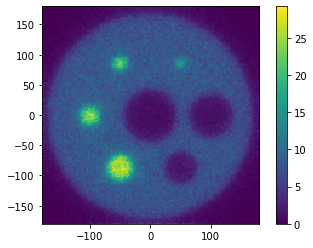

In [34]:
size   = (180, 180, 180)
show_image(image, zslice=shape[-1]//2, extent=size, ax=plt)
plt.colorbar()

In [7]:
def read_images_rust_it(path, vs, tof, tot_it):
    shape = (vs, vs, vs)
    reco_prefix = path + f'rust_images/{vs}_{vs}_{vs}_reco_1mm_no_jitter_tof_{tof}_'
    return np.array([wrap_1d_into_3d(read_raw(f'{reco_prefix}{it}.raw'), shape) for it in range(tot_it)])

from collections import namedtuple

im_path = '/Users/carmenromoluque/nexus_petit_analysis/full-body-phantom-paper/images_reco/photo_range1mm/'
##### voxel_size, tof
kinds  = ((180,  20),
          (180, 100),
          ( 60,  20),
          ( 60, 100))
tot_it     = 30
kind_tof   = namedtuple('kind', 'vs tof')
the_images = {kind_tof(vs=vs, tof=tof): read_images_rust_it(im_path, vs, tof, tot_it) 
              for vs, tof in kinds}

In [8]:
the_images;

In [14]:
def imshow_slice_integrated_along_z(ax, vs, tof, it, z_slice):
    if it < 1:
        it = 1
    image_slice = the_images[vs, tof][it,:,:,z_slice]
    im_integrated_along_z = np.sum(image_slice, axis=2).transpose()
    fig0 = ax.imshow(im_integrated_along_z, origin='lower')
    title = f'{vs} voxels, TOF {tof}ps'
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('X (mm)', fontsize=13)
    ax.set_ylabel('Y (mm)', fontsize=13)
    #fig.colorbar(fig0, ax=ax, label='Events')

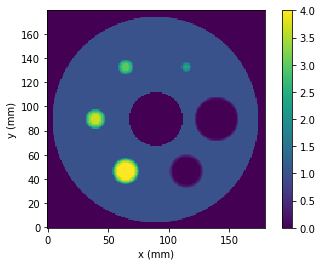

In [10]:
fig = plt.figure(1)

original_image = '/Users/carmenromoluque/Downloads/phantom_NEMAlike.npz'
d = np.load(original_image)
true_img = d['phantom']
plt.imshow(np.sum(true_img[:,:,81:99]/18,axis=2).transpose(),origin='lower')
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('y (mm)');

Iteration number: 1


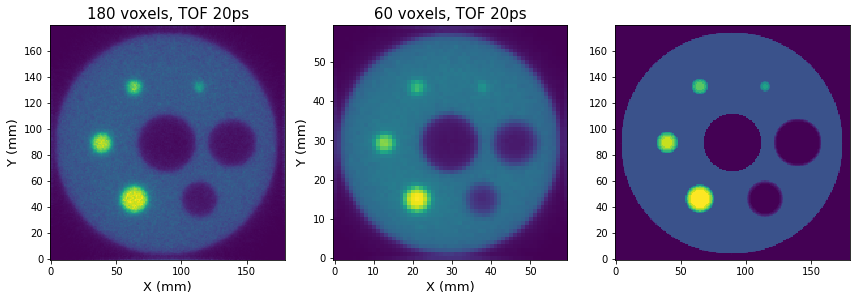

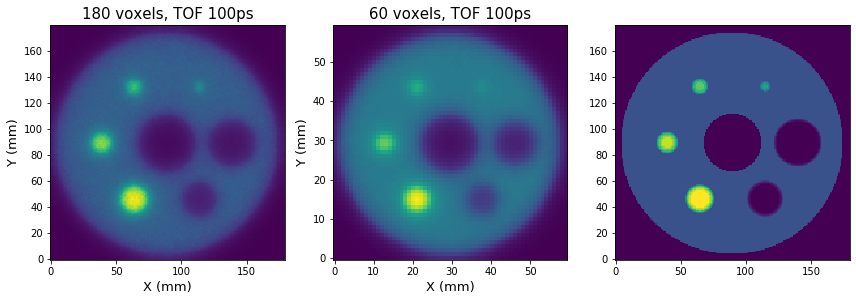

Iteration number: 10


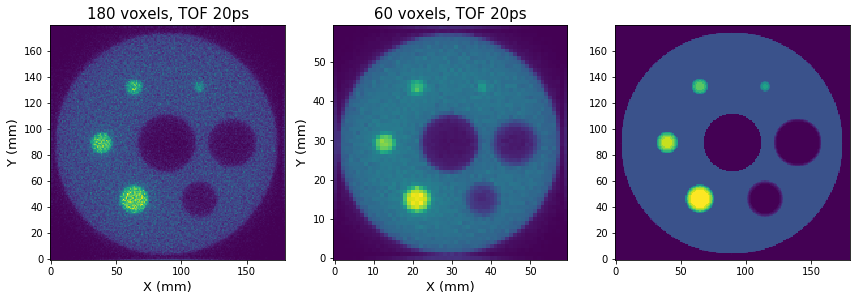

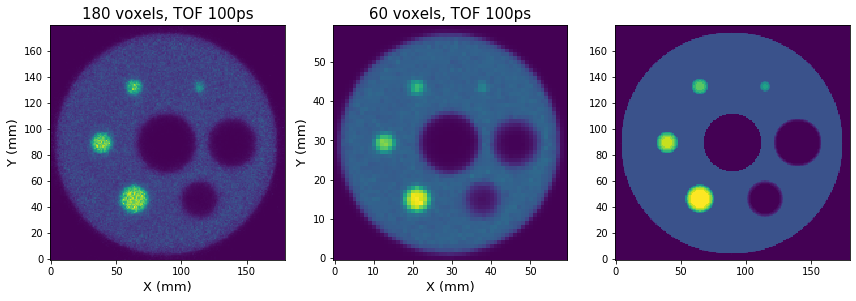

In [18]:
z_slice1 = slice(25,35)
z_slice2 = slice(85,95)
for it in [0, 9]:
    print(f'Iteration number: {it+1}')
    for tof in [20, 100]:
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4.5))
        imshow_slice_integrated_along_z(ax0, 180,  tof, it, z_slice2)
        #imshow_slice_integrated_along_z(ax1, 180, 100, it, z_slice2)
        imshow_slice_integrated_along_z(ax1,  60,  tof, it, z_slice1)
        #imshow_slice_integrated_along_z(ax3,  60, 100, it, z_slice1)
        ax2.imshow(np.sum(true_img[:,:,81:99]/18,axis=2).transpose(),origin='lower')
        plt.tight_layout()
        plt.show()

In [19]:
sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6

hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]
all_radii   = hot_radii + cold_radii

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]

x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

radii  = hot_radii  + cold_radii
angles = hot_angles + cold_angles

In [20]:
num_hot     = 4
num_cold    = 2
num_spheres = num_hot + num_cold

from collections import namedtuple

sph_tof = namedtuple('sph_tof', 'sph, vs, tof')
snr_err = namedtuple('snr_err', 'snrs, errs')

def get_snrs(images, vs, tof, n_sph):
    x_bins, y_bins, z_bins = vs, vs, vs
    calculate_snrs_and_errs = lambda images: fomf.snr3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                        bckg_radius, phi0, phi_step, n_phi, 
                                                        x_size, y_size, z_size,
                                                        x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_snrs_and_errs, images[vs, tof]))
    snrs = [r[0] for r in all_images]
    errs = [e[1] for e in all_images]
    print(tof, n_sph)
    return snr_err(snrs=snrs, errs=errs)

snrs = {sph_tof(sph=n_sph, vs=vs, tof=tof) :
        get_snrs(the_images, vs, tof, n_sph)
        for vs, tof in kinds
        for n_sph in range(num_spheres)}

20 0
20 1
20 2
20 3
20 4
20 5
100 0
100 1
100 2
100 3
100 4
100 5
20 0
20 1
20 2
20 3
20 4
20 5
100 0
100 1
100 2
100 3
100 4
100 5


In [21]:
from typing import Sequence
from typing import Dict

def plot_snr_sphs(snrs:    Dict[sph_tof, snr_err], 
                  spheres: Sequence[int],
                  vs:      int,
                  tof:     int,
                  num_it:  int):
    for n_sphere in spheres:
        sphere = snrs[sph_tof(sph=n_sphere, vs=vs, tof=tof)]
        plt.errorbar(x = list(range(num_it)),
                     y =    sphere.snrs[:num_it], 
                     yerr = sphere.errs[:num_it], 
                     xerr = None,
                     #color = color, 
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, v_size={vs}mm, TOF={tof}ps')

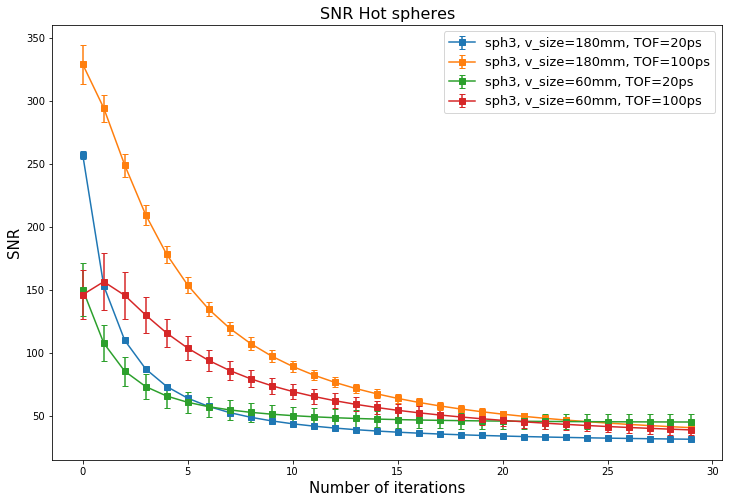

In [22]:
plt.figure(figsize=(12,8))
for vs, tof in kinds:
    plot_snr_sphs(snrs, range(3,4), vs=vs, tof=tof, num_it=30)
plt.title(f'SNR Hot spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=1, fontsize=13, ncol=1);

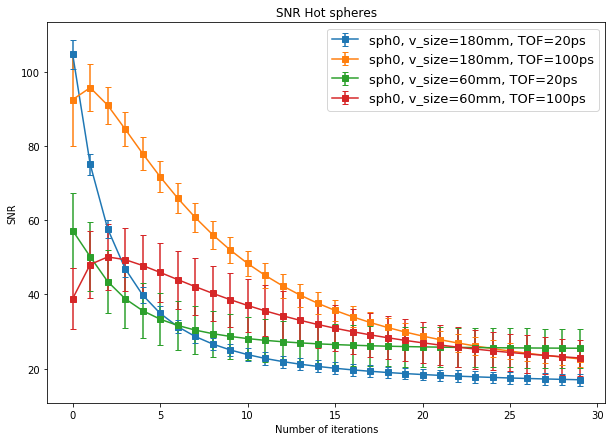

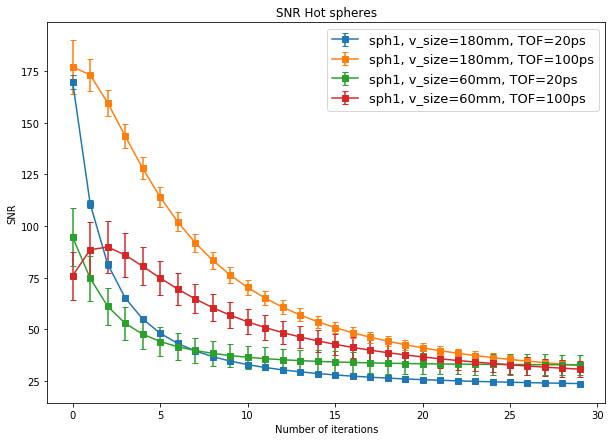

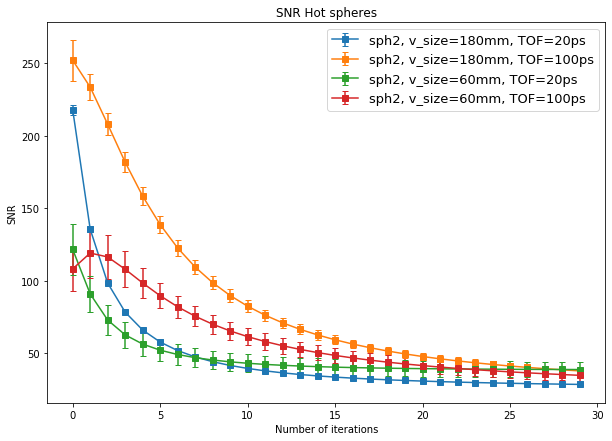

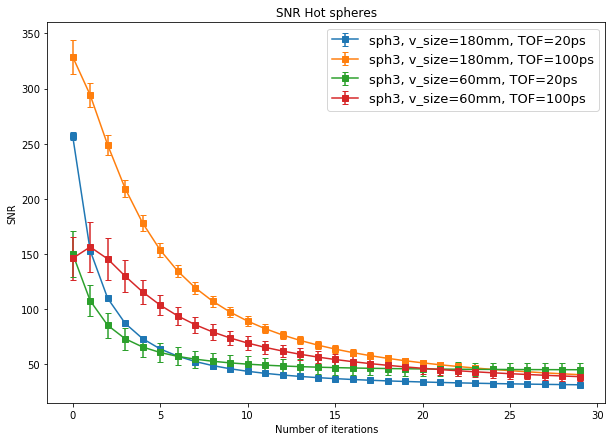

In [23]:
for sph in range(4):
    plt.figure(figsize=(10,7))
    for vs, tof in kinds:
        plot_snr_sphs(snrs, range(sph,sph+1), vs=vs, tof=tof, num_it=30)
    plt.title(f'SNR Hot spheres')
    plt.xlabel('Number of iterations')
    plt.ylabel('SNR')
    plt.legend(loc=1, fontsize=13, ncol=1)
    plt.show()

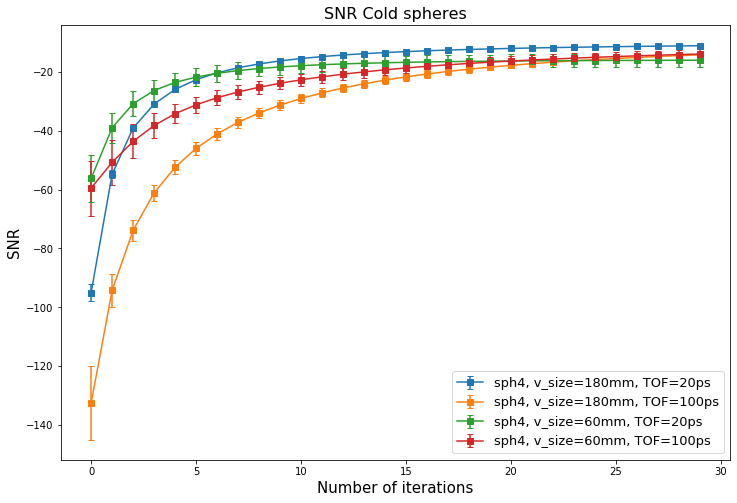

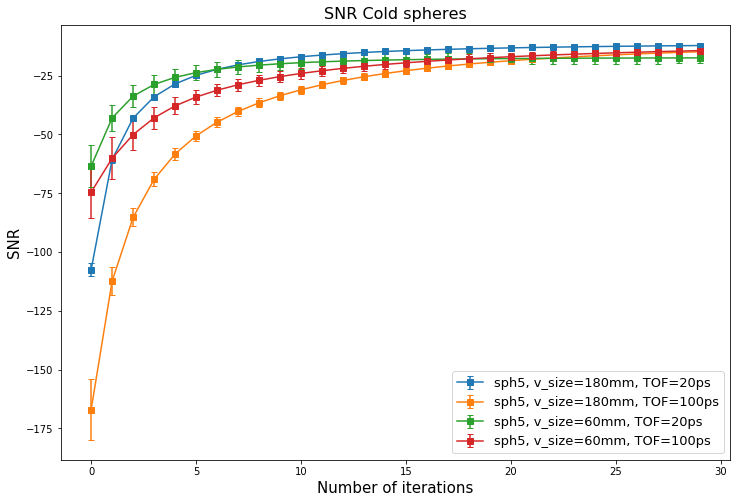

In [24]:
for sph in range(4,6):
    plt.figure(figsize=(12,8))
    for vs, tof in kinds:
        plot_snr_sphs(snrs, range(sph,sph+1), vs=vs, tof=tof, num_it=30)
    plt.title(f'SNR Cold spheres', fontsize=16)
    plt.xlabel('Number of iterations', fontsize=15)
    plt.ylabel('SNR', fontsize=15)
    plt.legend(loc=4, fontsize=13, ncol=1)
    plt.show()

## CRC

In [25]:
crc_err = namedtuple('crc_err', 'crcs, errs')
sig_intensity  =  4
bckg_intensity =  1

def get_crcs(images, vs, tof, n_sph):
    x_bins, y_bins, z_bins = vs, vs, vs
    calculate_crcs_and_errs = lambda images: fomf.crc_hot3d(images, sig_intensity, bckg_intensity, 
                                                            radii[n_sph], radial_pos, angles[n_sph], 
                                                            bckg_radius, phi0, phi_step, n_phi, 
                                                            x_size, y_size, z_size,
                                                            x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[vs, tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs = {sph_tof(sph=n_sph, vs=vs, tof=tof):
        get_crcs(the_images, vs, tof, n_sph)
        for vs, tof in kinds
        for n_sph in range(4)}

20 0
20 1
20 2
20 3
100 0
100 1
100 2
100 3
20 0
20 1
20 2
20 3
100 0
100 1
100 2
100 3


In [36]:
def get_crcs_cold(images, vs, tof, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_cold3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                             bckg_radius, phi0, phi_step, n_phi, 
                                                             x_size, y_size, z_size,
                                                             x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[vs, tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs_cold = {sph_tof(sph=n_sph, vs=vs, tof=tof):
             get_crcs_cold(the_images, vs, tof, n_sph)
             for vs, tof in kinds
             for n_sph in range(4, 6)}

20 4
20 5
100 4
100 5
20 4
20 5
100 4
100 5


In [37]:
def plot_crc_sphs(crcs:    Dict[sph_tof, crc_err], 
                  spheres: Sequence[int], 
                  vs:      int,
                  tof:     int,
                  num_it:  int):
    for n_sphere in spheres:
        sphere = crcs[sph_tof(sph=n_sphere, vs=vs, tof=tof)]
        plt.errorbar(x = list(range(num_it)),
                     y =    sphere.crcs[:num_it], 
                     yerr = sphere.errs[:num_it], 
                     xerr = None,
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, v_size={vs}mm, TOF={tof}ps')

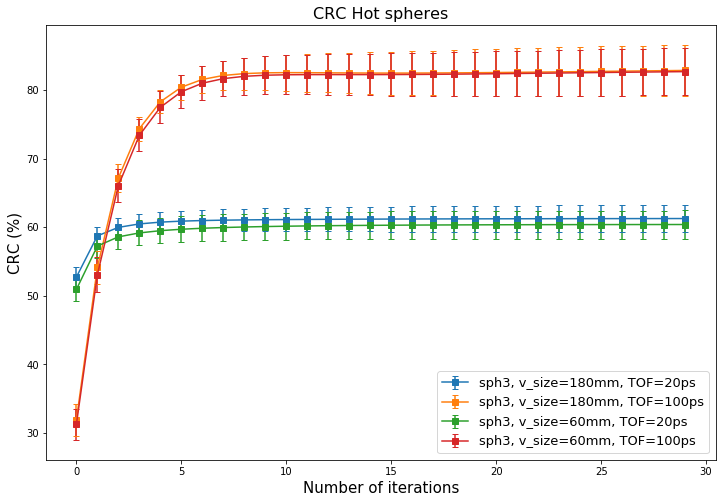

In [38]:
plt.figure(figsize=(12,8))
for vs, tof in kinds:
    plot_crc_sphs(crcs, range(3,4), vs=vs, tof=tof, num_it=30)
plt.title(f'CRC Hot spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('CRC (%)', fontsize=15)
plt.legend(loc=4, fontsize=13, ncol=1);

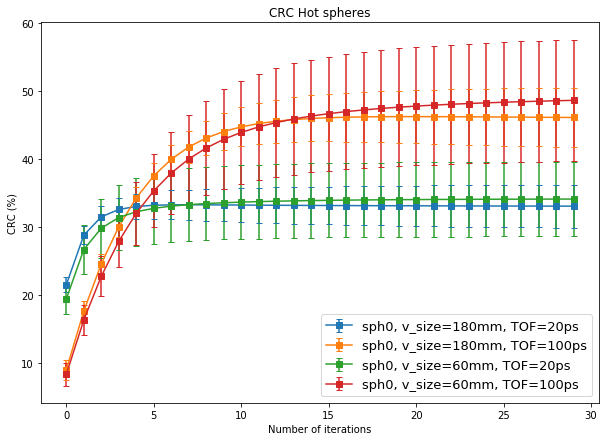

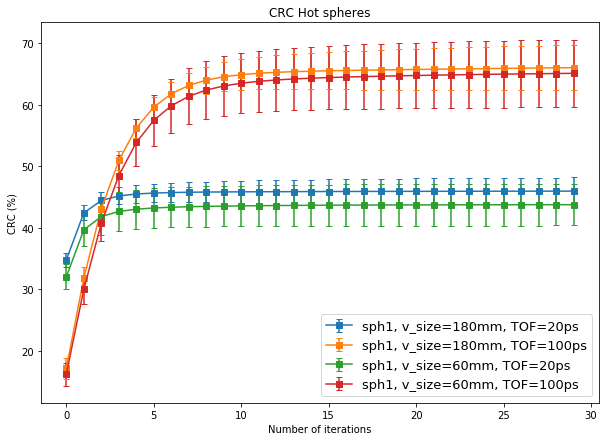

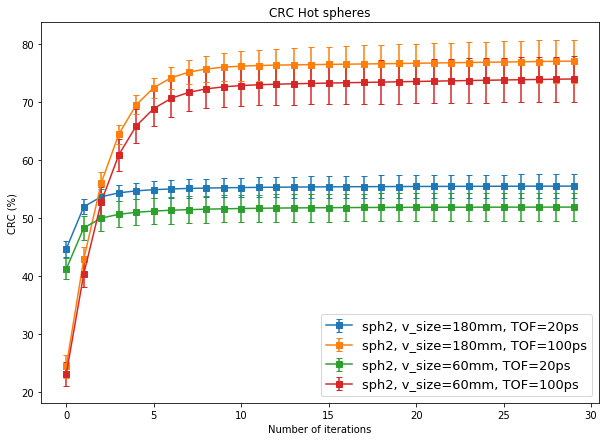

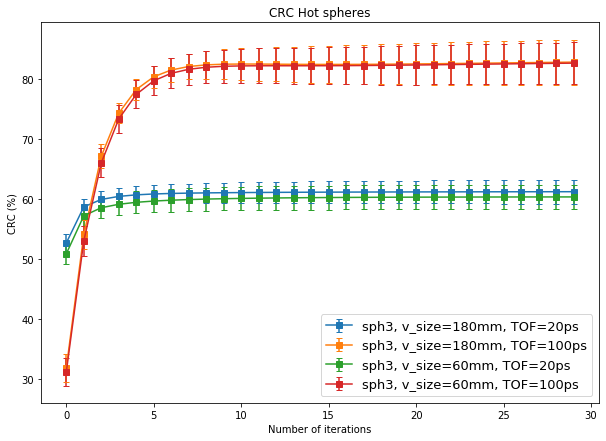

In [39]:
for sph in range(4):
    plt.figure(figsize=(10,7))
    for vs, tof in kinds:
        plot_crc_sphs(crcs, range(sph,sph+1), vs=vs, tof=tof, num_it=30)
    plt.title(f'CRC Hot spheres')
    plt.xlabel('Number of iterations')
    plt.ylabel('CRC (%)')
    plt.legend(loc=4, fontsize=13, ncol=1)
    plt.show()

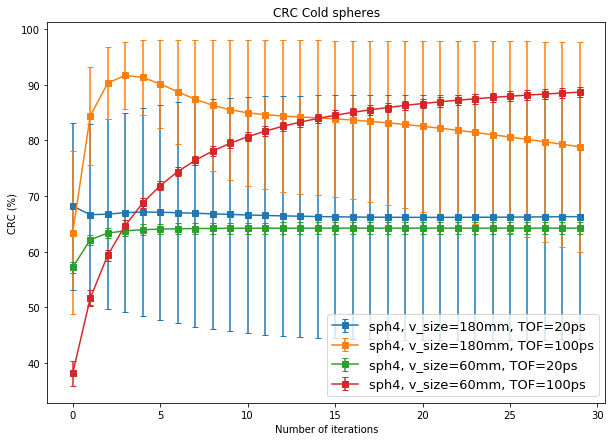

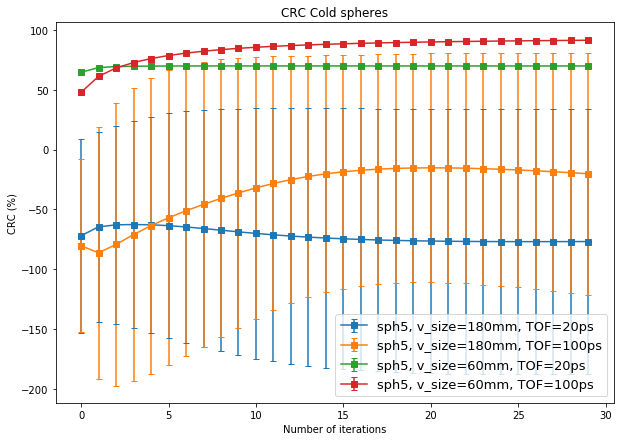

In [40]:
for sph in range(4,6):
    plt.figure(figsize=(10,7))
    for vs, tof in kinds:
        plot_crc_sphs(crcs_cold, range(sph,sph+1), vs=vs, tof=tof, num_it=30)
    plt.title(f'CRC Cold spheres')
    plt.xlabel('Number of iterations')
    plt.ylabel('CRC (%)')
    plt.legend(loc=4, fontsize=13, ncol=1)
    plt.show()